In [ ]:
!pip install omegaconf einops transformers
!pip install pytorch-lightning
!pip install pandas
# !pip install streamlit
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!git lfs install
!git clone https://huggingface.co/boris/vqgan_f16_16384

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 4.2 MB 36.7 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 117 kB 68.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.0 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=afd4f39ce2beb349f9d517c2f946b85249055faac14b78a131cce12864355df0
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 14.3 MB/s 
     |████████████████████████████████| 140 kB 70.8 MB/s 
     |████████████████████████████████| 419 kB 71.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.3 MB/s 
     |████████████████████████████████| 271 kB 73.5 MB/s 
     |████████████████████████████████| 144 kB 77.1 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 28.35 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/taming-transformers
Updated git hooks.
Git LFS initialized.
Cloning into 'vqgan_f16_16384'...
remote: Enumerating objects: 16, done.
r

In [ ]:

%cd taming-transformers

/content/taming-transformers


In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch

from pathlib import Path
import pandas as pd
from tqdm import tqdm
from omegaconf import OmegaConf
import yaml

In [ ]:
from taming.models.vqgan import VQModel
config_path = "./vqgan_f16_16384/config.yaml"
config = OmegaConf.load(config_path)
yaml.dump(OmegaConf.to_container(config))

'model:\n  base_learning_rate: 4.5e-06\n  params:\n    ddconfig:\n      attn_resolutions:\n      - 16\n      ch: 128\n      ch_mult:\n      - 1\n      - 1\n      - 2\n      - 2\n      - 4\n      double_z: false\n      dropout: 0.0\n      in_channels: 3\n      num_res_blocks: 2\n      out_ch: 3\n      resolution: 256\n      z_channels: 256\n    embed_dim: 256\n    lossconfig:\n      params:\n        codebook_weight: 1.0\n        disc_conditional: false\n        disc_in_channels: 3\n        disc_num_layers: 2\n        disc_start: 0\n        disc_weight: 0.75\n      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator\n    n_embed: 16384\n  target: taming.models.vqgan.VQModel\n'

In [ ]:
vqgan = VQModel(**config.model.params)
ckpt_path = "./vqgan_f16_16384/model.ckpt"
sd = torch.load(ckpt_path)["state_dict"]
missing, unexpected = vqgan.load_state_dict(sd, strict=False)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/kodalle/1024-0.0005/checkpoint-40000 /content/

In [ ]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

In [ ]:
bart = BartForConditionalGeneration.from_pretrained('/content/checkpoint-40000')
tokenizer = PreTrainedTokenizerFast.from_pretrained('/content/checkpoint-40000')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
vqgan = vqgan.cuda()
bart = bart.cuda()

In [ ]:
img_size = 256
n_token = (img_size//16)**2
n_col, n_row = 4, 2
n_samples = n_row*n_col
bad = [[*range(16384, 30000)]]
img_size, n_token

(256, 256)

In [ ]:
prompt = '밤하늘을 나는 비행기'
text_token = torch.LongTensor(tokenizer.encode(prompt)).reshape([1, -1]).cuda()
text_token

tensor([[15294, 23598, 12007, 14651, 18262,  9264]], device='cuda:0')

In [ ]:
encoding = bart.generate(text_token,
                         min_length=n_token+2,
                         max_length=n_token+2,
                         do_sample=True,
                         temperature=1.,
                         top_k=512,
                         num_return_sequences=n_samples,
                         bad_words_ids=bad)[:, 1: -1]
print(encoding.size())
print(encoding.max(axis=1).values > 16384)

torch.Size([8, 256])
tensor([False, False, False, False, False, False, False, False],
       device='cuda:0')


In [ ]:
code_from_quant = vqgan.quantize.get_codebook_entry(
    encoding, [-1, img_size//16, img_size//16, 256])
dec = vqgan.decode(code_from_quant)
dec = dec.detach().cpu()
dec_image = dec.permute([0, 2, 3, 1]).numpy().clip(-1, 1)
dec_image = ((dec_image + 1) * 127.5).astype(np.uint8)
dec_image = dec_image.reshape([-1, img_size, img_size, 3])
dec_image.shape

(8, 256, 256, 3)

(512, 1024, 3)


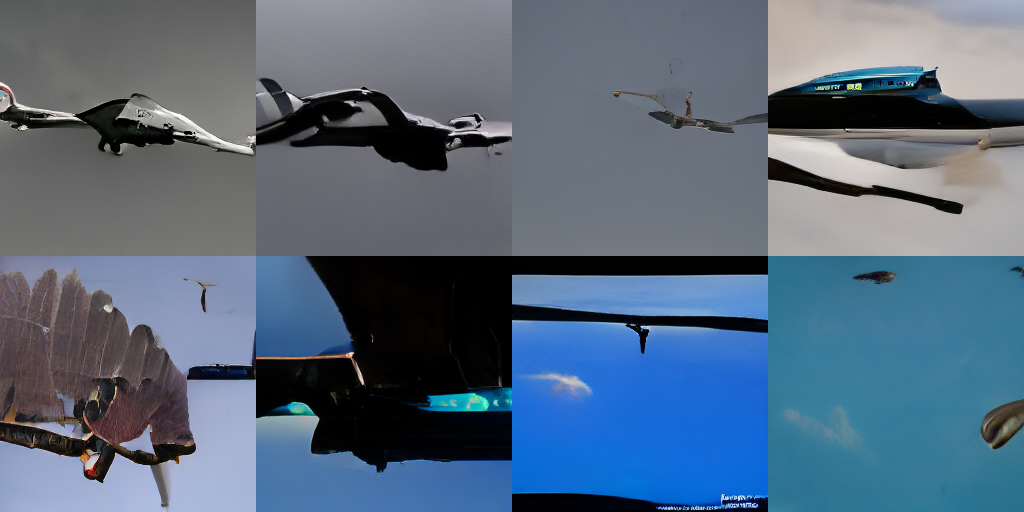

In [ ]:
img_all = np.concatenate(
    [np.concatenate(dec_image[i*n_col:(i+1)*n_col], axis=1) for i in range(n_row)]
, axis=0)
print(img_all.shape)
display(Image.fromarray(img_all))

In [ ]:
!nvidia-smi

Tue Jun 14 04:20:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |  15699MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------